Create database

Next steps:
- Show by ingredient (i.e. top fat delivering ingredients, etc.)
- Calc net carbs only when I want to use the information in dashboard, not on top (so I don't have to carry it with me all along the way when doing manipulations).

Stored 'foods' (DataFrame)
Stored 'myfoods' (DataFrame)
Stored 'pa_meals' (dict)


UsageError: Unknown variable 'fa_meals'


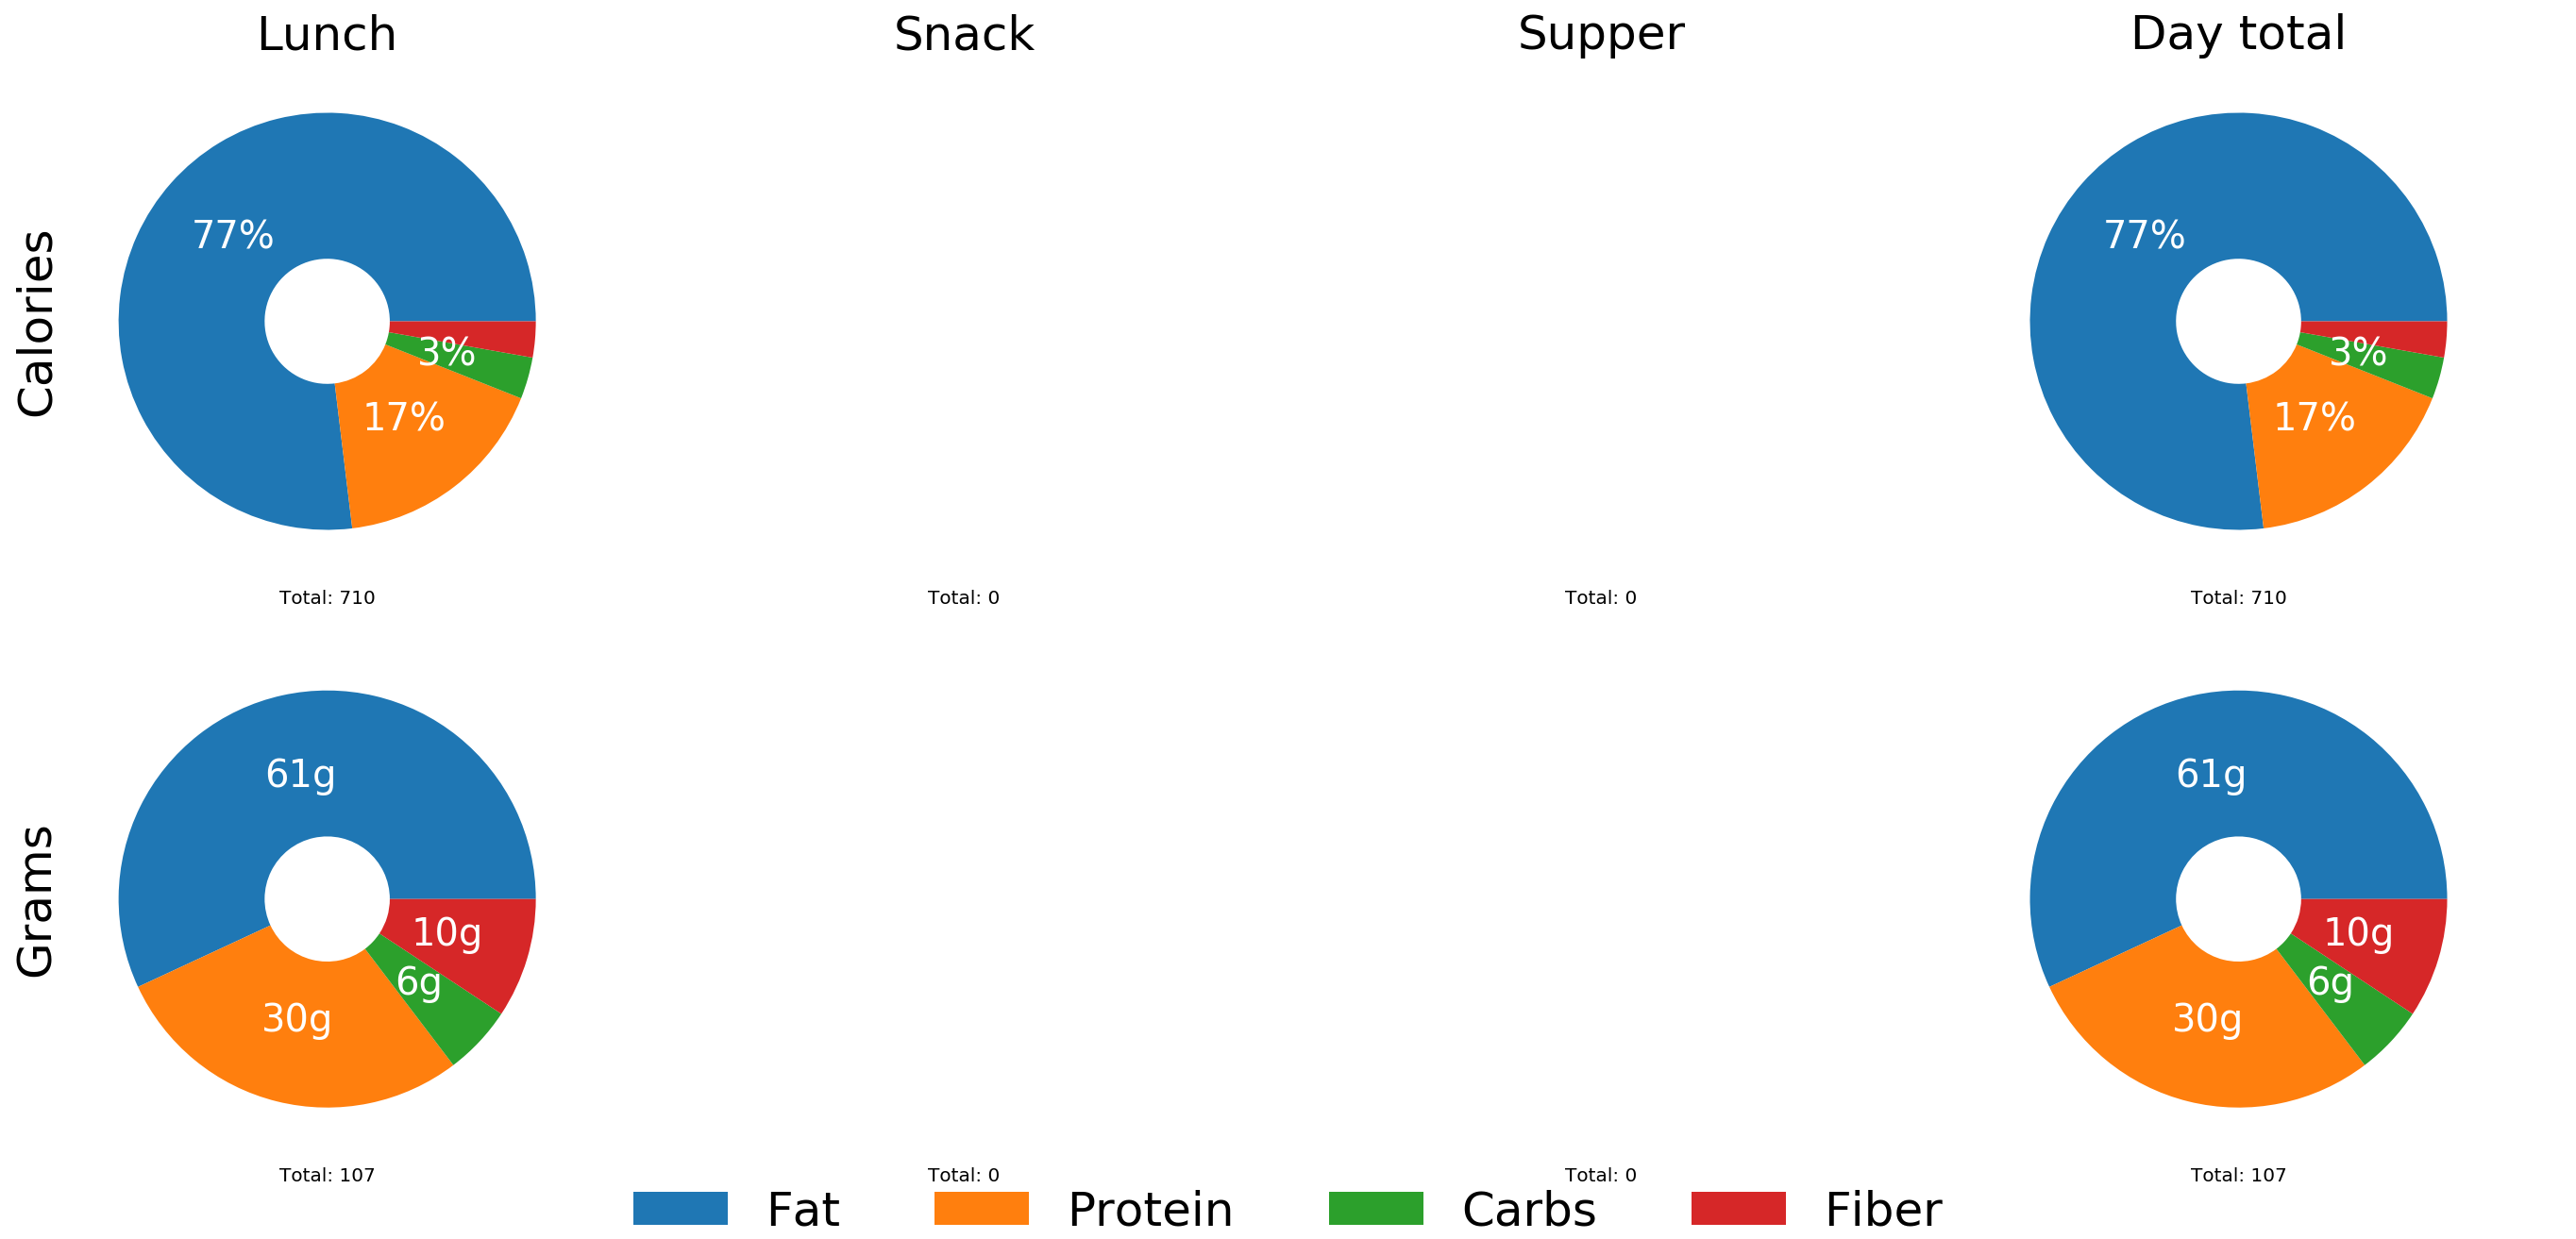

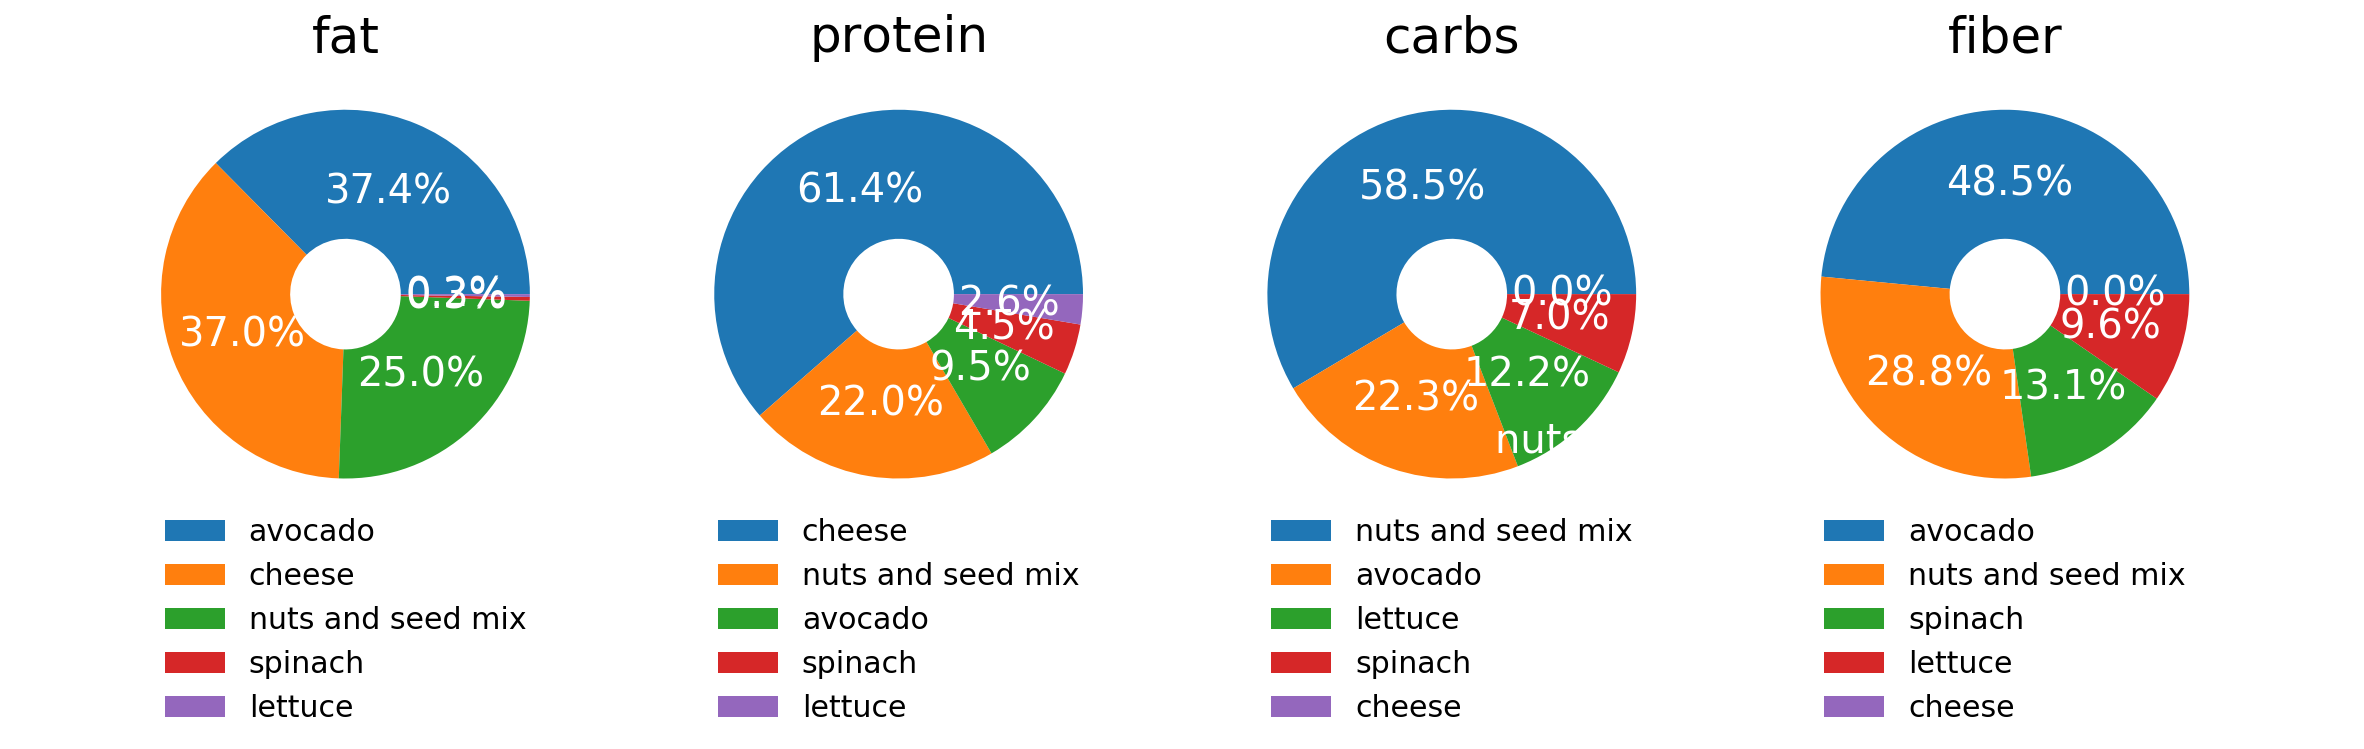

In [1]:
%run make_data.ipynb
%store -r myfoods

%run meals.ipynb
%store -r pa_meals fa_meals


%config InlineBackend.figure_format ='retina'


def calc_nuts(meals, include_total=True):
    """Calculate nutrient content for each meal and for daily total."""
    
    def calc_meal_nuts(meal_dic, data=myfoods):
        """Calculate nutrient content for a meal."""
        columns = ['fat', 'protein', 'carbs', 'fiber']
        cals_per_g = {'fat': 9, 'carbs': 4, 'protein': 4, 'fiber': 2} 
        
        def calc_share(group):
            group['share'] = group.value / group.value.sum()
            return group
        
        df = (data
              .loc[data.index.isin(meal_dic), columns]
              .reset_index()
              .melt(id_vars='ingredient', var_name='nutrient', value_name='grams')
              .assign(portion = lambda x: x.ingredient.map(meal_dic))
              .assign(grams = lambda x: x.grams * x.portion)
              .assign(cals_per_gram = lambda x: x.nutrient.map(cals_per_g))
              .assign(cals = lambda x: x.grams * x.cals_per_gram)
              .drop(['cals_per_gram', 'portion'], axis=1)
              .melt(id_vars=['ingredient', 'nutrient'],
                    var_name='measure')
              .groupby('measure')
              .apply(calc_share)
              .assign(nutrient = lambda df: pd.Categorical(df.nutrient, ['fat', 'protein', 'carbs', 'fiber']))
             )

        return df
    
    
    def add_total(data):
        total = data.copy()
        total['share'] = total.share / total.meal.nunique()
        total = data.groupby(['ingredient', 'nutrient', 'measure']).sum()
        total['meal'] = 'Day total'
        total.reset_index(inplace=True)
        df = pd.concat([data, total], ignore_index=True)
        
        meal_order = list(meals.keys())
        meal_order.append('Day total')
        df['meal'] = pd.Categorical(df.meal, meal_order)
        df = df.sort_values(['measure', 'meal', 'nutrient'])

        return df
    
    
    def make_meals_plot_data(data):
        return data.groupby(['measure', 'meal', 'nutrient'], as_index=False).sum()
        

    pieces = []
    for meal in meals:
        df = calc_meal_nuts(meals[meal])
        df['meal'] = meal
        pieces.append(df)    
    data = pd.concat(pieces)
        
    if include_total:
        data = add_total(data)
        
    data_table = data    
    meals_plot_data = make_meals_plot_data(data)
    
    
    return data_table, meals_plot_data


def make_dashboard(data):
    
    title_size = 25
    label_size = 20
    nrows = data.measure.nunique()
    ncols = data.meal.nunique()
    
    
    def pct_labels(pct, df, measure):
        if measure == 'cals':
            return f'{pct:.0f}%' if pct > 3 else ''
        elif measure == 'grams':
            grams = pct / 100 * df.value.sum()
            return f'{grams:.0f}g' if grams > 5 else ''
    
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(19, 9))
            
    for row, measure in enumerate(data.measure.unique()):
        for col, meal in enumerate(data.meal.unique()):
            df = data.loc[(data.measure == measure) & (data.meal == meal)]
            ax[row, col].pie(df.share,
                             labels=df.nutrient,
                             textprops=dict(color='white', size=label_size),
                             wedgeprops=dict(width=.7),
                             autopct=lambda pct: pct_labels(pct, df, measure)
                            )
            ax[row, col].set_xlabel(f'Total: {df.value.sum():.0f}')

    # Set column and row labels
    ax[0, 0].set_ylabel('Calories', fontsize=title_size)
    ax[1, 0].set_ylabel('Grams', fontsize=title_size)
    for col, name in enumerate(data.meal.unique()):
        ax[0, col].set_title(name, fontsize=title_size)

    legend_labs = [n.capitalize().replace('_', ' ') for n in data.nutrient.unique()]
    fig.legend(legend_labs, loc='lower center', ncol=4, fontsize=title_size, 
               framealpha=0, borderaxespad=-0.3)
    fig.tight_layout();
    
    
def make_nutrient_graphs(data):
    
    title_size = 25
    label_size = 20
    
    def get_top(group, n):
        return group.sort_values('share', ascending=False)[:n]

    def calc_share(group):
        group['share'] = group.value / group.value.sum()
        return group

    data = data.groupby(['measure', 'meal', 'nutrient']).apply(calc_share)
    conds = (data.measure == 'cals') & (data.meal == 'Day total')
    data = data.loc[conds].groupby(['meal', 'nutrient']).apply(get_top, 5)

    fig, ax = plt.subplots(1, len(data.nutrient.unique()), figsize=(19, 9))

    for col, nutrient in enumerate(data.nutrient.unique()):
        df = data.loc[data.nutrient == nutrient]
        ax[col].pie(df.share,
                 labels=df.ingredient,
                 textprops=dict(color='white', size=label_size),
                 wedgeprops=dict(width=.7),
                 autopct='%1.1f%%'
                )
        ax[col].set_title(nutrient, fontsize=title_size)
        ax[col].legend(loc='lower center', ncol=1, fontsize=15, 
                   framealpha=0, borderaxespad=-7)


fab_meals = {
    
    'Lunch': {
        'cheese': 0.7,
        'coconut fat': 0,
        'eggs': 0,
        'leek': 0,
        'mushrooms': 0,
        'spinach': 0.5,
        
        'avocado': 1.6,
        'lettuce': 0.5,
        'nuts and seed mix': 0.3,        
        'olive oil': 0,
        'red pepper': 0,
    },
    
    'Snack': {
        'nuts and seed mix': 0,
        'cheese': 0,
    },

    'Supper': {
        'chicken': 0,
        'vegetables': 0,
        'coconut fat': 0,
    }
}
    

nuts, meals_plot_data = calc_nuts(fab_meals, include_total=True)
make_dashboard(meals_plot_data)
make_nutrient_graphs(nuts)


# Need warning when I add foods to meals that aren't in database
# add sugar

# Old pipeline

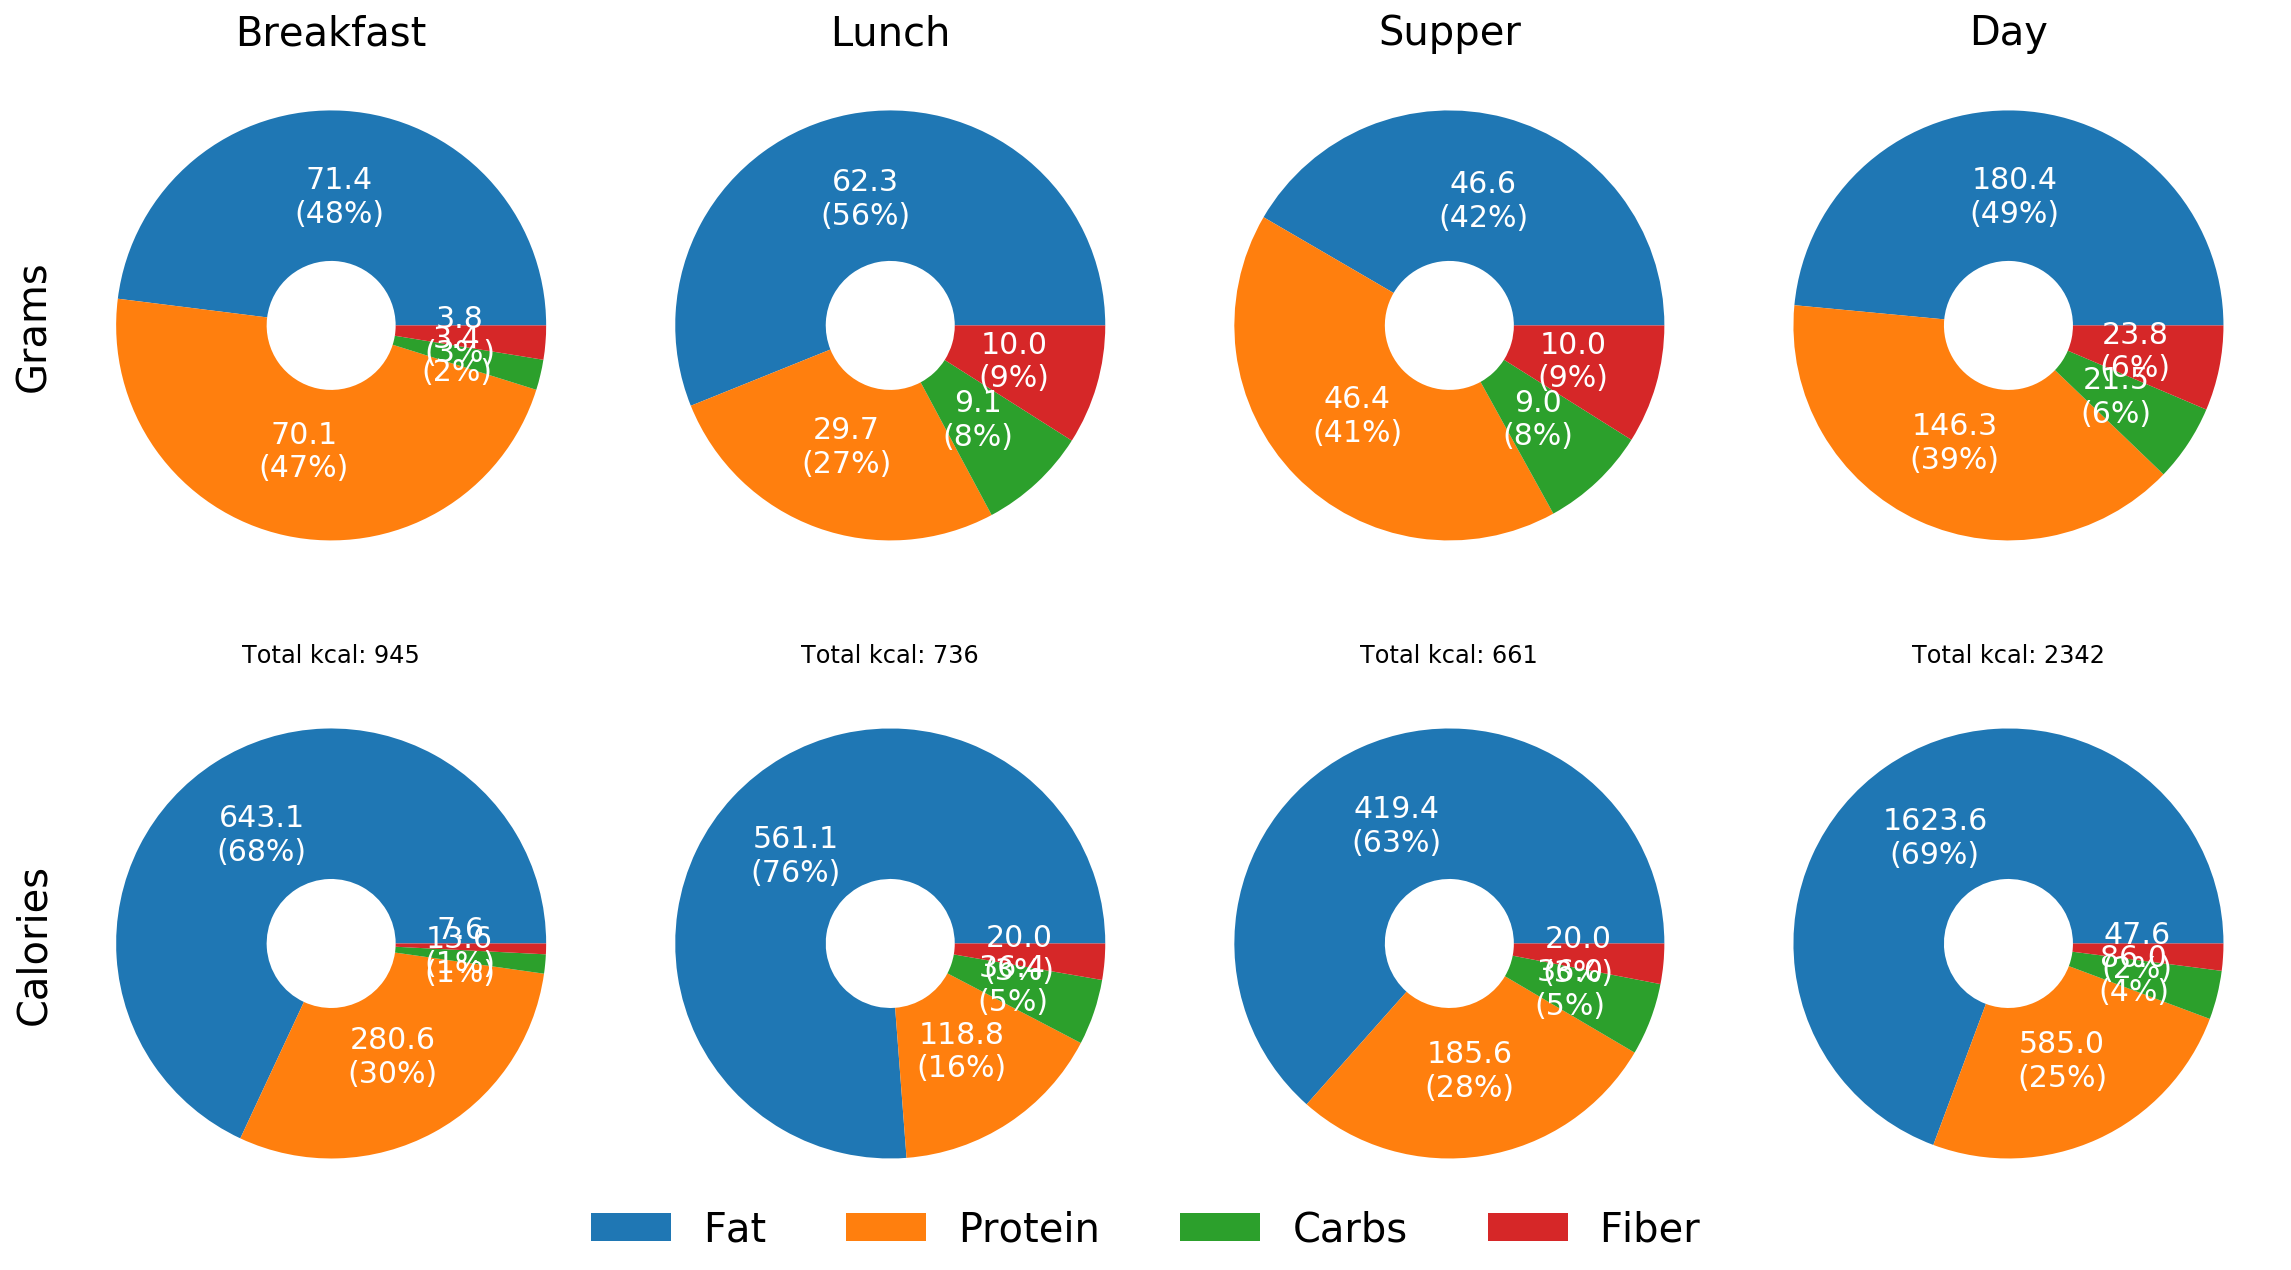

In [2]:
def calc_meal_nuts(data, meal):
    
    def make_multiindex(df):
        measure = df.columns.str.extract('^(.+?)_', expand=False)
        nutrient = df.columns.str.extract('_(.+?)$', expand=False)
        tuples = zip(measure, nutrient)
        idx = pd.MultiIndex.from_tuples(tuples, names=['measure', 'nutrient'])
        df.columns = idx
        return df
    
    def read(data):
        columns = ['calories', 'fat', 'protein', 'carbs', 'fiber']
        macros = ['fat', 'protein', 'carbs', 'fiber']
        portions = list(meal.values())   
        df = (data
              .loc[data.index.isin(meal), columns]
              .reindex(meal) # Order rows for portion multiplication
              .multiply(portions, axis=0)
              .assign(total=lambda df: df[macros].sum(axis=1))
              .add_prefix('grams_')
              .rename(columns = {'grams_calories': 'cals_total'})
              .assign(cals_fat = lambda df: df.grams_fat * 9)
              .assign(cals_protein = lambda df: df.grams_protein * 4)
              .assign(cals_carbs = lambda df: df.grams_carbs * 4)
              .assign(cals_fiber = lambda df: df.grams_fiber * 2)
#               .assign(cals_net_carbs=lambda df: df.grams_net_carbs * 4)
              .pipe(make_multiindex)
              .stack()
              .swaplevel(0, 1)
              .sort_index())
        
        df[df < 0] = 0
        return df

    return read(data)


def make_nuts_dict(meals):
    meal_nuts = {meal: calc_meal_nuts(myfoods, meals[meal]).sum(level='nutrient') for meal in meals}
    meal_nuts['Day'] = sum([meal_nuts[meal] for meal in meal_nuts])
    return meal_nuts


def make_dashboard(meals):
        
    rows = ['fat', 'protein', 'carbs', 'fiber']
    
    def make_doughnut(meal_data, column, axis, meal_num, meal_name):
        nuts = meal_data.loc[rows]
        
        def labs(pct, nuts):
            absolute = pct / 100 * nuts[column].sum()
            if pct < 0.5:
                return f''
            else:
                return f'{absolute:.1f}\n({pct:.0f}%)'

        ax[axis, meal_num].set_title(f'Total kcal: {nuts[column].sum():.0f}')
        ax[axis, meal_num].pie(nuts[column],
                               autopct=lambda pct: labs(pct, nuts),
                               textprops=dict(color='white', size=15),
                               wedgeprops=dict(width=.7))
        
        
    fig, ax = plt.subplots(2, len(meals), figsize=(16, 9))

    # Plot grams (top) and calories (bottom) for each meal
    for meal_num, meal_name in enumerate(meals):
        make_doughnut(meals[meal_name], 'grams', 0, meal_num, meal_name)
        make_doughnut(meals[meal_name], 'cals', 1, meal_num, meal_name)

    # Set column and row labels
    ax[0, 0].set_ylabel('Grams', fontsize=20)
    ax[1, 0].set_ylabel('Calories', fontsize=20)
    for col, name in enumerate(meals):
        ax[0, col].set_title(name, fontsize=20)

    legend_labs = [r.capitalize().replace('_', ' ') for r in rows]
    fig.legend(legend_labs, loc='lower center', ncol=4, fontsize=20, 
               framealpha=0, borderpad=0)
    fig.tight_layout()
    
    

meals = {
    
    'Breakfast': {
        'cauliflower': 1,
        'cheese': 1.5,
        'eggs': 2,
        'spinach': 0.5,
    },

    'Lunch': {
        'lettuce': 1.5,
        'nuts and seed mix': .5,        
        'olive oil': .3,
        'tofu': 2,
    },

    'Supper': {
        'avocado': 2,
        'butter': 0,
        'trout': 2,
        'vegetables': 2,
    }
}
    
meal_nuts = make_nuts_dict(meals)
make_dashboard(meal_nuts)